<a href="https://colab.research.google.com/github/Aditya-founder/Selection/blob/main/strokeData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, round as pyspark_round, sum as pyspark_sum , when
from pyspark.ml.feature import StringIndexer, VectorAssembler, MinMaxScaler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
spark = SparkSession.builder.appName("HealthcareAnalysis").getOrCreate()

data = spark.read.csv('healthcare-dataset-stroke-data.csv', header=True, inferSchema=True)

data = data.drop('id')

data.printSchema()

data.describe().show()

missing_values = data.select([(col(c).isNull().cast("int").alias(c)) for c in data.columns])

missing_values_summary = missing_values.agg(*[
    pyspark_round((pyspark_sum(col(c)) / data.count()) * 100, 2).alias(c) for c in data.columns
])

missing_values_summary.show()


data = data.withColumn("bmi", when(col("bmi") == "N/A", None).otherwise(col("bmi").cast("double")))
data = data.na.drop()

cols = data.columns[:-1]
print(cols)

data.show()

root
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: string (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- stroke: integer (nullable = true)

+-------+------+------------------+------------------+-------------------+------------+---------+--------------+------------------+------------------+--------------+-------------------+
|summary|gender|               age|      hypertension|      heart_disease|ever_married|work_type|Residence_type| avg_glucose_level|               bmi|smoking_status|             stroke|
+-------+------+------------------+------------------+-------------------+------------+---------+--------------+------------------+------------------+--------

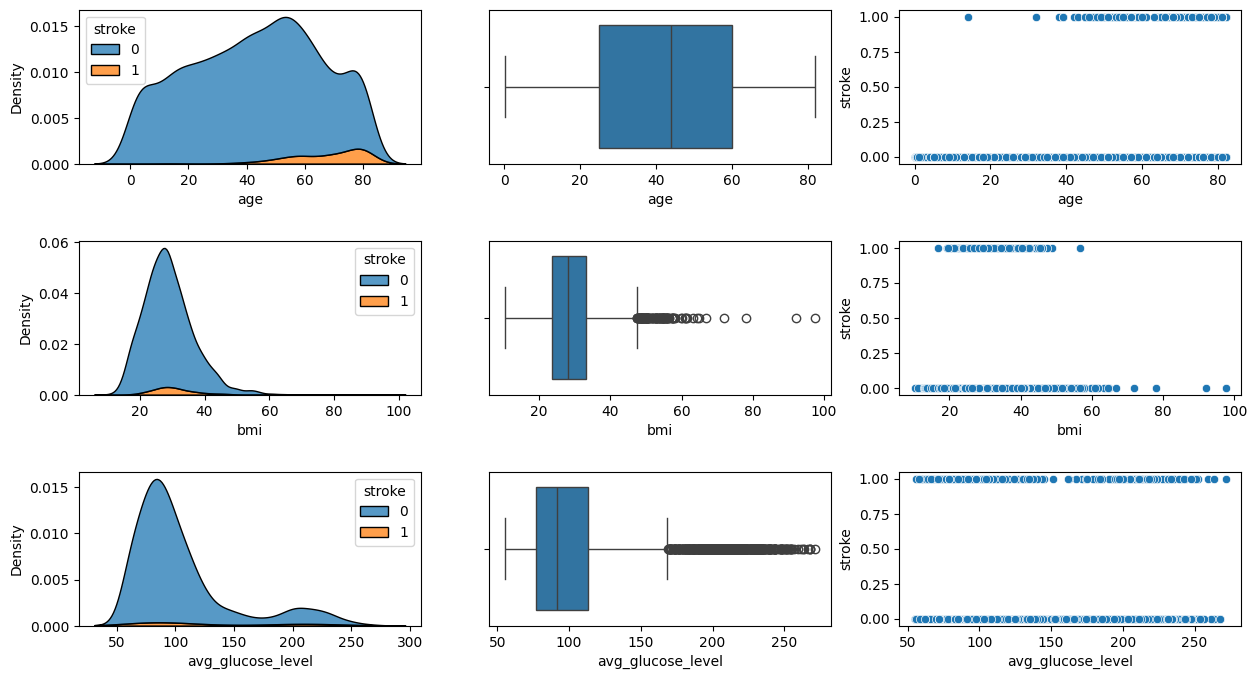

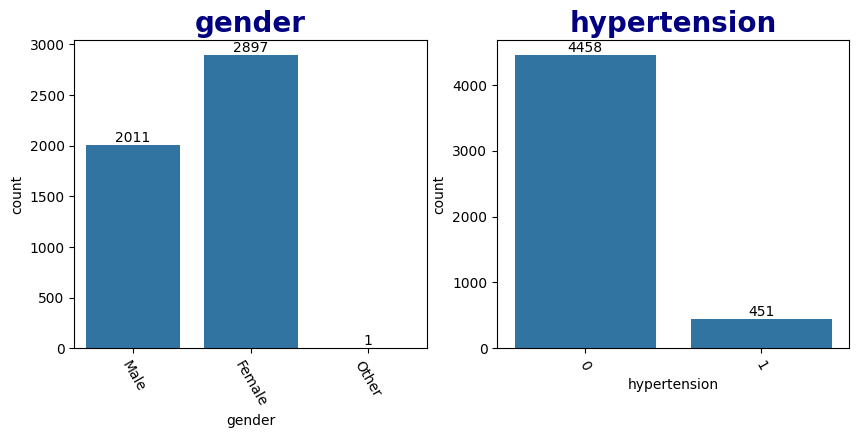

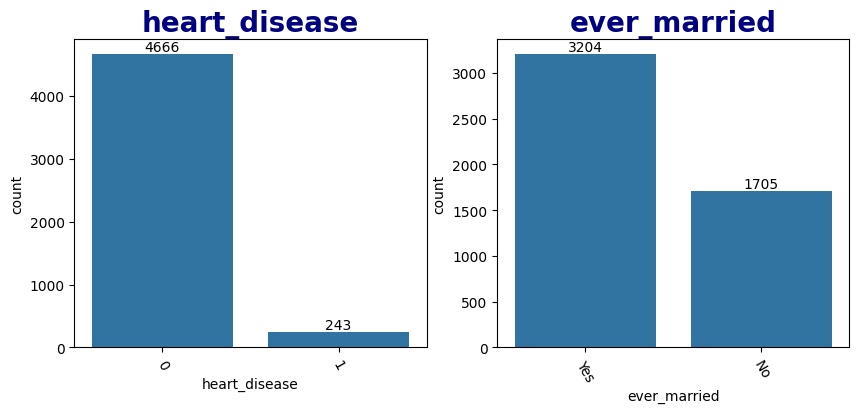

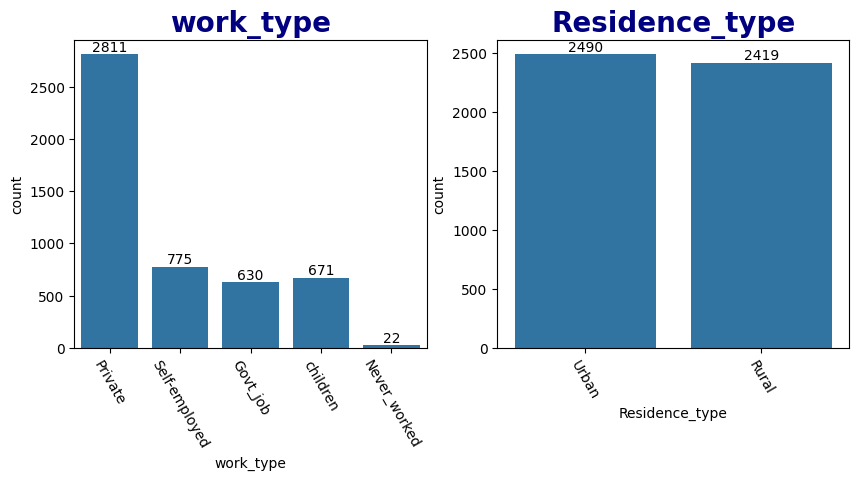

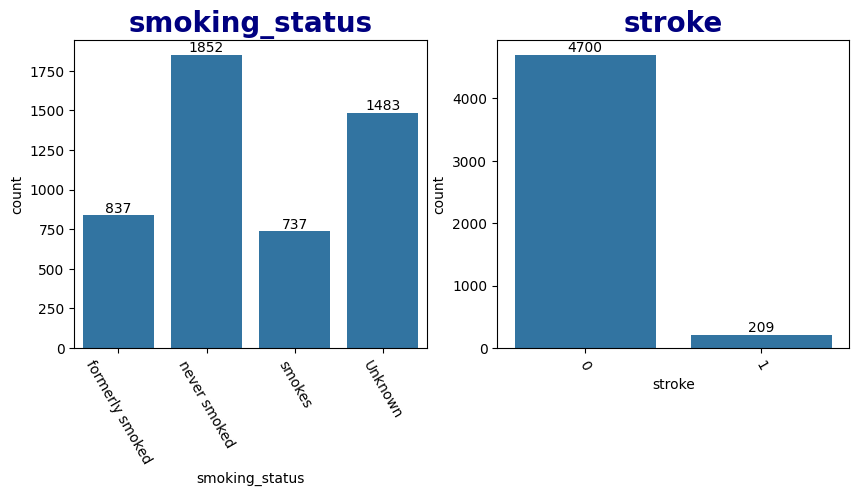

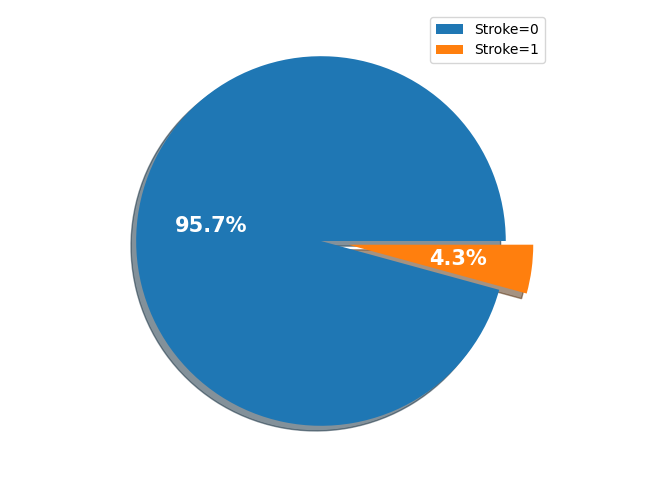

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
data_pd = data.toPandas()
data_pd['bmi'] = pd.to_numeric(data_pd['bmi'], errors='coerce')

numeric_columns = ['age', 'bmi', 'avg_glucose_level']
categorical_columns = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status', 'stroke']

i = 0
fig, ax = plt.subplots(3, 3, figsize=(15, 8))
plt.subplots_adjust(hspace=0.5)
for num_col in numeric_columns:
    sns.kdeplot(x=num_col, hue='stroke', data=data_pd, multiple='stack', ax=ax[i, 0])
    sns.boxplot(x=num_col, data=data_pd, ax=ax[i, 1])
    sns.scatterplot(x=num_col, y='stroke', data=data_pd, ax=ax[i, 2])
    i += 1
plt.show()

i = 0
while i < 8:
    fig = plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.title(categorical_columns[i], size=20, weight='bold', color='navy')
    ax = sns.countplot(x=categorical_columns[i], data=data_pd)
    ax.bar_label(ax.containers[0])
    ax.tick_params(axis='x', rotation=300)
    i += 1

    if i < 8:
        plt.subplot(1, 2, 2)
        plt.title(categorical_columns[i], size=20, weight='bold', color='navy')
        ax = sns.countplot(x=categorical_columns[i], data=data_pd)
        ax.bar_label(ax.containers[0])
        ax.tick_params(axis='x', rotation=300)
        i += 1
    plt.show()

x = data_pd['stroke'].value_counts()
explode = [0, 0.15]
labels = ['Stroke=0', 'Stroke=1']
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(aspect="equal"))
plt.pie(x, explode=explode, shadow=True, autopct='%1.1f%%', labels=labels, textprops=dict(color="w", weight='bold', size=15))
plt.legend()
plt.show()


RandomForestClassifier Accuracy: 0.955


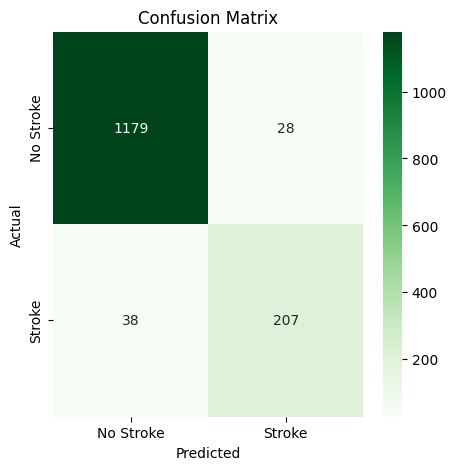

In [ ]:
from pyspark.sql.functions import col


categorical_columns = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
indexers = [StringIndexer(inputCol=col, outputCol=col+'_index', handleInvalid='keep') for col in categorical_columns]

numeric_columns = ['age', 'bmi', 'avg_glucose_level', 'hypertension', 'heart_disease']

assembler = VectorAssembler(inputCols=[col+'_index' for col in categorical_columns] + numeric_columns, outputCol='features')

scaler = MinMaxScaler(inputCol='features', outputCol='scaled_features')

rf = RandomForestClassifier(labelCol='stroke', featuresCol='scaled_features', numTrees=100)

from pyspark.ml import Pipeline
pipeline = Pipeline(stages=indexers + [assembler, scaler, rf])

minority_class = data.filter(col('stroke') == 1)
majority_class = data.filter(col('stroke') == 0)
oversampled_minority = minority_class.sample(True, 5.0)  # Adjust factor based on class ratio
balanced_data = majority_class.union(oversampled_minority)

train_data, test_data = balanced_data.randomSplit([0.75, 0.25], seed=0)

paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [50, 100, 250, 500]) \
    .addGrid(rf.maxDepth, [5, 10]) \
    .build()

cv = CrossValidator(estimator=pipeline, estimatorParamMaps=paramGrid, evaluator=MulticlassClassificationEvaluator(labelCol='stroke', metricName='accuracy'), numFolds=10)

cvModel = cv.fit(train_data)

best_model = cvModel.bestModel
model_path = "random_forest_model"
best_model.write().overwrite().save(model_path)

y_pred = best_model.transform(test_data)

evaluator = MulticlassClassificationEvaluator(labelCol='stroke', metricName='accuracy')
accuracy = evaluator.evaluate(y_pred)
print(f'RandomForestClassifier Accuracy: {accuracy:.3f}')


def plot_confusion_matrix(y_pred):
    cm = y_pred.select("stroke", "prediction").toPandas()
    cm = cm.groupby(["stroke", "prediction"]).size().unstack(fill_value=0)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, cmap='Greens', fmt='d', xticklabels=['No Stroke', 'Stroke'], yticklabels=['No Stroke', 'Stroke'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(y_pred)
